In [1]:
import os
import random
from datetime import datetime
import pandas as pd
import numpy as np
import time

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import uuid

from torchvision.models import resnet34, ResNet34_Weights


c:\Python3.9\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
torch.cuda.is_available()

True

In [3]:
# Load the CSV file into a DataFrame
csv_file_path = 'detection_output.csv'  
df = pd.read_csv(csv_file_path)
df

,image,y_min,x_min,y_max,x_max,class
0,detection_images/image0.jpg,-8.193441,110.34774,186.35568,328.82650,2
1,detection_images/image1.jpg,125.819050,247.00010,184.60208,309.07740,2
2,detection_images/image2.jpg,11.844065,241.73372,103.00182,322.29960,2
3,detection_images/image3.jpg,104.019455,327.84220,152.51675,371.39093,2
4,detection_images/image4.jpg,46.750690,216.08687,134.57740,321.92587,5
5,detection_images/image5.jpg,20.225578,270.51938,108.31572,337.88550,5
6,detection_images/image6.jpg,35.086193,273.91345,148.59015,336.72620,5
7,detection_images/image7.jpg,71.098490,241.04372,136.94296,316.76556,6
8,detection_images/image8.jpg,2.482155,238.06706,149.07541,349.18190,6
9,detection_images/image9.jpg,31.260338,156.43070,217.76566,354.46100,6


Cropping according to the predicted bounding box coordinates and the saving the images 

In [4]:
# Creating a folder to store cropped images
output_folder = 'cropped_images'
os.makedirs(output_folder, exist_ok=True)

# Iterating through the rows of the DataFrame
for index, row in df.iterrows():
    # Getting the image file path and bounding box values
    image_path = str(row['image'])
    x_min, y_min, x_max, y_max = map(int, [row['x_min'], row['y_min'], row['x_max'], row['y_max']])
    label = row['class']

    image = Image.open(image_path)

    # Crop the image using the bounding box values
    cropped_image = image.crop((x_min, y_min, x_max, y_max))

    # Save the cropped image to a folder based on the class label
    class_folder = os.path.join(output_folder, f'label_{label}')
    os.makedirs(class_folder, exist_ok=True)
    
    save_path = os.path.join(class_folder, f'cropped_{index}.png')
    cropped_image.save(save_path)

    cropped_image.close()

print("Cropping and saving complete.")

Cropping and saving complete.


Resizing the images according to the LeNET architecture

In [5]:
def resize_images_in_folder(input_folder, output_folder, target_size=(224, 224)):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            
            # Read and resize the image
            img = cv2.imread(input_path)
            resized_img = cv2.resize(img, target_size)
            
            # Save the resized image
            cv2.imwrite(output_path, resized_img)

label0_folder = "Projects/Combined_models/cropped_images/label_0"
output_folder_label0 = "Projects/Combined_models/cropped_resized_images/label_0"

label1_folder = "Projects/Combined_models/cropped_images/label_1"
output_folder_label1 = "Projects/Combined_models/cropped_resized_images/label_1"

label2_folder = "Projects/Combined_models/cropped_images/label_2"
output_folder_label2 = "Projects/Combined_models/cropped_resized_images/label_2"

label3_folder = "Projects/Combined_models/cropped_images/label_3"
output_folder_label3 = "Projects/Combined_models/cropped_resized_images/label_3"

label4_folder = "Projects/Combined_models/cropped_images/label_4"
output_folder_label4 = "Projects/Combined_models/cropped_resized_images/label_4"

label5_folder = "Projects/Combined_models/cropped_images/label_5"
output_folder_label5 = "Projects/Combined_models/cropped_resized_images/label_5"

label6_folder = "Projects/Combined_models/cropped_images/label_6"
output_folder_label6 = "Projects/Combined_models/cropped_resized_images/label_6"

# Resize images in the input folder and save in the output folder
resize_images_in_folder(label0_folder, output_folder_label0, target_size=(224, 224))
resize_images_in_folder(label1_folder, output_folder_label1, target_size=(224, 224))
resize_images_in_folder(label2_folder, output_folder_label2, target_size=(224, 224))
resize_images_in_folder(label3_folder, output_folder_label3, target_size=(224, 224))
resize_images_in_folder(label4_folder, output_folder_label4, target_size=(224, 224))
resize_images_in_folder(label5_folder, output_folder_label5, target_size=(224, 224))
resize_images_in_folder(label6_folder, output_folder_label6, target_size=(224, 224))

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)

Creating the TestLoader

In [7]:
label0_images = [os.path.join(output_folder_label0, filename) for filename in os.listdir(output_folder_label0)]
label1_images = [os.path.join(output_folder_label1, filename) for filename in os.listdir(output_folder_label1)]
label2_images = [os.path.join(output_folder_label2, filename) for filename in os.listdir(output_folder_label2)]
label3_images = [os.path.join(output_folder_label3, filename) for filename in os.listdir(output_folder_label3)]
label4_images = [os.path.join(output_folder_label4, filename) for filename in os.listdir(output_folder_label4)]
label5_images = [os.path.join(output_folder_label5, filename) for filename in os.listdir(output_folder_label5)]
label6_images = [os.path.join(output_folder_label6, filename) for filename in os.listdir(output_folder_label6)]

# Combine image paths and labels into tuples for each label
data_label0 = list(zip(label0_images, [0] * len(label0_images)))
data_label1 = list(zip(label1_images, [1] * len(label1_images)))
data_label2 = list(zip(label2_images, [2] * len(label2_images)))
data_label3 = list(zip(label3_images, [3] * len(label3_images)))
data_label4 = list(zip(label4_images, [4] * len(label4_images)))
data_label5 = list(zip(label5_images, [5] * len(label5_images)))
data_label6 = list(zip(label6_images, [6] * len(label6_images)))

# Combine all data_label lists into a single list for the test_set
test_set = data_label0 + data_label1 + data_label2 + data_label3 + data_label4 + data_label5 + data_label6

# Shuffle the test set
random.seed(42)
test_set = shuffle(test_set, random_state=42)

# Unzip the shuffled data to get the final test_set
test_set, labels_test = zip(*test_set)

# Convert to NumPy arrays
test_set = np.array(test_set)
labels_test = np.array(labels_test)

# Print the number of images in the test set
print(f"Test set size: {len(test_set)}")


Test set size: 24


In [8]:
from collections import Counter

# Count occurrences of each label in the testing set
test_label_counts = Counter(labels_test)

# Print the counts for test set
print("Test set label counts:", test_label_counts)

Test set label counts: Counter({2: 4, 4: 4, 3: 4, 0: 3, 5: 3, 6: 3, 1: 3})


Displaying the final cropped and resized images with its labels

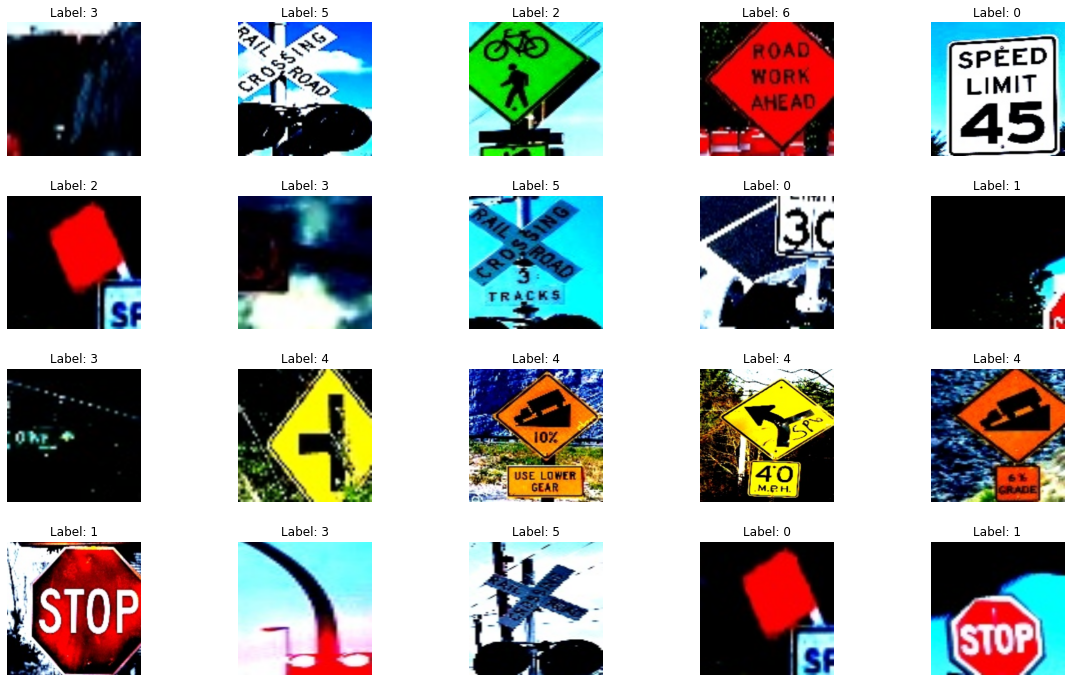

In [9]:

def display_images(images, labels):
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.3)

    for i, ax in enumerate(axes.flat):
        img_path = images[i]
        label = labels[i]

        # Load and display the image
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {label}")

    plt.show()

# Display 10 random images with aligned labels
random_indices = random.sample(range(len(test_set)), 20)
random_images = [test_set[i] for i in random_indices]
random_labels = [labels_test[i] for i in random_indices]

display_images(random_images, random_labels)

Defining the Classification Model

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1_size = 64 * 53 * 53  
        self.fc1 = nn.Linear(self.fc1_size, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc1_size)  
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.fc2(x)
        return x


In [12]:

# Convert test images to PyTorch tensors
test_images_tensor = torch.stack([torchvision.transforms.ToTensor()(Image.open(img_path)) for img_path in test_set])
test_labels_tensor = torch.tensor(labels_test)

# Create a custom test dataset
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)


Loading the saved model, and testing it on the test_data

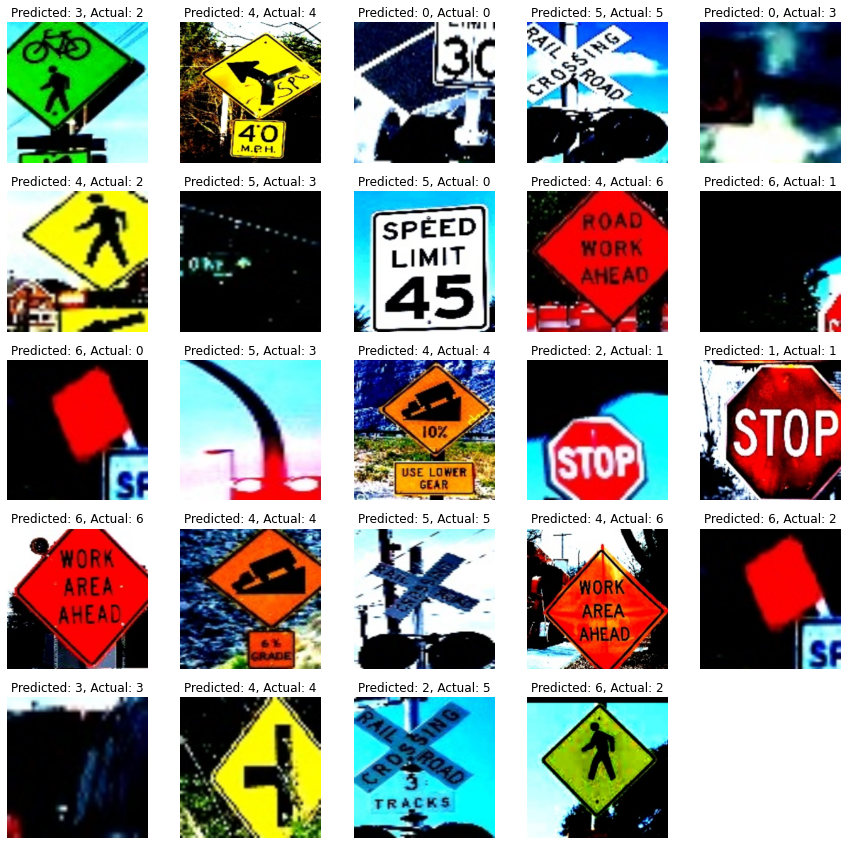

In [13]:
# Define a function to display images in a grid
def display_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i].permute(1, 2, 0))
            ax.set_title(titles[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LeNet()  
model = torch.load("Projects/Road-Sign-Detection/best_model.pth")
model.to(device)

# Show all images from the testing set with predicted labels
num_images_to_show = len(test_dataset)  # Use all images in the test set

# Lists to store images and titles
display_images_list = []
display_titles_list = []

for idx in range(num_images_to_show):  # Loop over all images in the test set
    with torch.no_grad():
        inputs, labels = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append image and title to the lists
        display_images_list.append(inputs.cpu().squeeze())
        display_titles_list.append(f"Predicted: {predicted.item()}, Actual: {labels}")

# Display images in a grid with 5 images per row
num_images = len(display_images_list)
rows = (num_images + 4) // 5  # Ensure there are at least 5 images per row

display_images(display_images_list, display_titles_list, rows, 5)
